In [1]:
import tensorflow as tf
from tensorflow.keras import Model,layers
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint,Callback
from tensorflow.keras import metrics,optimizers
import numpy as np
from PIL import Image
from pathlib import Path
import os
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow_hub as hub
from sklearn.metrics import confusion_matrix,roc_curve,roc_auc_score
from sklearn.metrics import classification_report

In [2]:
#Setting up images path
# Linux path
PATH = "/home/changsmarter/Desktop/myAI_Project/10000_PHASE1/"
SELECTED_CLASS = "10000_NoF_Class.csv"
SELECTED_LABEL = "Is No_Finding"
SUB = 'temp'
LABEL = 'NoF_fix1_'
data_dir = Path(PATH)
image_num = len(list(data_dir.glob(SUB+'/*/*/*.jpg')))
image_csv = pd.read_csv(PATH+SELECTED_CLASS)
CLASS_NAME = image_csv[SELECTED_LABEL].unique()
# Check number of TRUE file and all file count        
print(image_num)
print(CLASS_NAME)

10000
['No' 'Yes']


In [3]:
##loading image from given path
my_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
BATCH_SIZE = 32
IMG_WIDTH = 224
IMG_HEIGHT = 224
TRAIN_PATH = PATH + SUB + "/train/"
VALID_PATH = PATH + SUB + "/valid/"
TEST_PATH = PATH + SUB + "/test/"
#This will be my train_set . 
data_gen_train = my_generator.flow_from_directory(directory=TRAIN_PATH,
                                                  batch_size=BATCH_SIZE,
                                                  shuffle=True,
                                                  target_size=(IMG_HEIGHT,IMG_WIDTH),
                                                  color_mode='rgb')
#This will be my valid_set . 
data_gen_valid = my_generator.flow_from_directory(directory=VALID_PATH,
                                                 batch_size=BATCH_SIZE,
                                                 shuffle=True,
                                                 target_size=(IMG_HEIGHT,IMG_WIDTH),
                                                 color_mode='rgb')
#This will be my test_set . 
data_gen_test = my_generator.flow_from_directory(directory=TEST_PATH,
                                                 batch_size=BATCH_SIZE,
                                                 shuffle=True,
                                                 target_size=(IMG_HEIGHT,IMG_WIDTH),
                                                 color_mode='rgb')
x_train,y_train = next(data_gen_train)
x_valid,y_valid = next(data_gen_valid)
x_test,y_test = next(data_gen_test)

Found 8001 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [4]:
##Using ResNet50
myResnet = hub.KerasLayer("https://tfhub.dev/google/imagenet/resnet_v2_50/classification/4"
                          ,trainable=False,
                         input_shape=(224,224,3))
 
myModel = tf.keras.Sequential([
    myResnet,
    layers.BatchNormalization(),
    layers.Dense(1024,activation='relu'),
    layers.Dense(512,activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(2,activation='softmax')
])
#myModel.build([None,224,224,3])

In [5]:
myModel.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1001)              25615849  
_________________________________________________________________
batch_normalization (BatchNo (None, 1001)              4004      
_________________________________________________________________
dense (Dense)                (None, 1024)              1026048   
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 1026      
Total params: 27,171,727
Trainable params: 1,553,876
Non-trainable params: 25,617,851
____________________________________

In [6]:
## Setting up callback function for detecting training status
myEarly = EarlyStopping(monitor='val_loss',patience=3,verbose=1)
myCheckpoint = ModelCheckpoint('Model2/'+LABEL+'ResNet50.hdf5'
                               ,monitor='val_loss')
#Callback function when my model hit my max ACC
class mystopclass(Callback):
    def on_epoch_end(self,epoch,log={}):
        if(log.get('accuracy') > 0.999 or log.get('loss') < 0.001):
            print("\n\nReached my Destination. Stoppped Training!!\n\n")
            self.model.stop_training = True
myStop = mystopclass()

In [7]:
myModel.compile(loss='binary_crossentropy',
                    optimizer=optimizers.SGD(lr=1e-4)
                ,metrics=['accuracy'])

In [8]:
TRAIN_IMG = 8000
TEST_IMG = 1000
VALID_IMG = 1000

In [9]:
#Training myModel
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
STEP_PER_EPOCH = np.ceil(TRAIN_IMG/BATCH_SIZE)
VALID_STEP = np.ceil(VALID_IMG/BATCH_SIZE)
mySession = myModel.fit_generator(data_gen_train,
                               validation_data=data_gen_valid,
                               epochs = 50,
                               steps_per_epoch=STEP_PER_EPOCH,
                               validation_steps = VALID_STEP,
                               verbose = 2,
                               callbacks=[myCheckpoint,myStop])
tpr = dict()
fpr = dict()
auc = dict()
for i in range(0,5):
    print('====FOLD',i+1,'====')
    myModel.fit_generator(data_gen_train,
                               validation_data=data_gen_valid,
                               epochs = 10,
                               steps_per_epoch=STEP_PER_EPOCH,
                               validation_steps = VALID_STEP,
                               verbose = 2,
                               callbacks=[myEarly,myCheckpoint,myStop])
    
    y_pred = myModel.predict_generator(data_gen_test)
    pred = np.argmax(y_pred,axis=1)
    auc[i] = roc_auc_score(data_gen_test.classes,pred)
    tpr[i],fpr[i],_ = roc_curve(data_gen_test.classes,pred)
    
myModel.save('Model2/'+LABEL+'ResNet50_done.h5')

Train for 250.0 steps, validate for 32.0 steps
Epoch 1/50
250/250 - 34s - loss: 0.5799 - accuracy: 0.7490 - val_loss: 0.4256 - val_accuracy: 0.8390
Epoch 2/50
250/250 - 26s - loss: 0.5384 - accuracy: 0.7927 - val_loss: 0.4195 - val_accuracy: 0.8410
Epoch 3/50
250/250 - 25s - loss: 0.5077 - accuracy: 0.8120 - val_loss: 0.4163 - val_accuracy: 0.8430
Epoch 4/50
250/250 - 25s - loss: 0.5129 - accuracy: 0.8094 - val_loss: 0.4127 - val_accuracy: 0.8430
Epoch 5/50
250/250 - 26s - loss: 0.5140 - accuracy: 0.8137 - val_loss: 0.4093 - val_accuracy: 0.8430
Epoch 6/50
250/250 - 26s - loss: 0.4992 - accuracy: 0.8180 - val_loss: 0.4060 - val_accuracy: 0.8430
Epoch 7/50
250/250 - 25s - loss: 0.4912 - accuracy: 0.8188 - val_loss: 0.4034 - val_accuracy: 0.8420
Epoch 8/50
250/250 - 25s - loss: 0.4870 - accuracy: 0.8141 - val_loss: 0.4019 - val_accuracy: 0.8440
Epoch 9/50
250/250 - 25s - loss: 0.4883 - accuracy: 0.8180 - val_loss: 0.4006 - val_accuracy: 0.8440
Epoch 10/50
250/250 - 25s - loss: 0.4846 - a

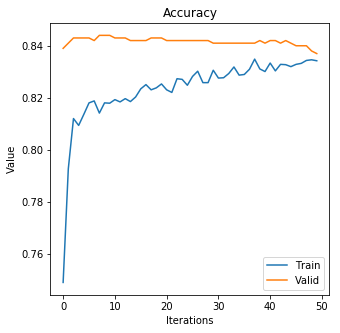

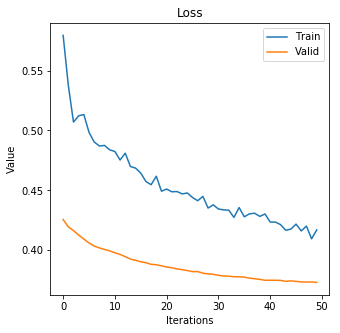

In [10]:
plt.figure(figsize=(5,5))
plt.plot(mySession.history['accuracy'])
plt.plot(mySession.history['val_accuracy'])
plt.title('Accuracy')
plt.ylabel('Value')
plt.xlabel('Iterations')
plt.legend(['Train','Valid'])
plt.savefig('Run_Result2/'+LABEL+"ResNet50_Acc.png")
plt.show()
plt.figure(figsize=(5,5))
plt.plot(mySession.history['loss'])
plt.plot(mySession.history['val_loss'])
plt.title('Loss')
plt.ylabel('Value')
plt.xlabel('Iterations')
plt.legend(['Train','Valid'])
plt.savefig('Run_Result2/'+LABEL+"ResNet50_Loss.png")
plt.show()

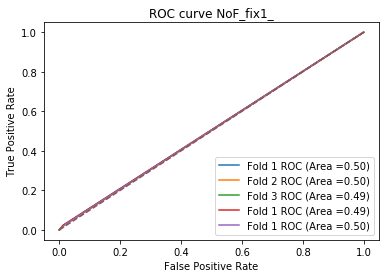

In [11]:
plt.plot(fpr[0],tpr[0],label='Fold 1 ROC (Area =%0.2f)' %auc[0])
plt.plot(fpr[1],tpr[1],label='Fold 2 ROC (Area =%0.2f)' %auc[1])
plt.plot(fpr[2],tpr[2],label='Fold 3 ROC (Area =%0.2f)' %auc[2])
plt.plot(fpr[3],tpr[3],label='Fold 1 ROC (Area =%0.2f)' %auc[3])
plt.plot(fpr[4],tpr[4],label='Fold 1 ROC (Area =%0.2f)' %auc[4])
plt.plot([0,1],[0,1],linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve '+LABEL)
plt.legend(loc='lower right')
plt.savefig('Run_Result2/'+LABEL+"ResNet50_5ROC.png")
plt.show()

In [12]:
y_pred = myModel.predict_generator(data_gen_test)
pred = np.argmax(y_pred,axis=1)
print(classification_report(data_gen_test.classes,pred))

             precision    recall  f1-score   support

          0       0.84      0.97      0.90       844
          1       0.12      0.02      0.03       156

avg / total       0.73      0.82      0.77      1000

